### PyTorch Libraries

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter

In [2]:
import torch 
print(torch.__version__)

1.2.0


In [3]:
torch.cuda.is_available()

False

### Extarct Transform & Loading 

In [7]:
# using torchvision to access the dataset
# using torchvision.transform, image is transformed
# into pytorch.tensors
# 60,000 images in training data
# 10,000 images in testing data

'''
EXTRACT & TRANSFORM
'''

train = datasets.FashionMNIST("",
                       train=True,
                       download=True,
                       transform=transforms.Compose([transforms.ToTensor()]))  
test = datasets.FashionMNIST("",
                       train=False,
                       download=True,
                       transform=transforms.Compose([transforms.ToTensor()]))  

In [8]:
# Dataloader wraps the dataset into
# dataloader instance, which is helpful 
# to perform specific operations such as
# batching(size=10), shuffle etc.

'''
LOADING DATA
'''

trainset = torch.utils.data.DataLoader(train,batch_size=10,shuffle=True)
testset = torch.utils.data.DataLoader(test,batch_size=10,shuffle=True)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
torch.set_printoptions(linewidth =120)

### Analyzing datasets

In [10]:
'''
Creating a counter function to 
count the number of labels in 
each of the datasets i.e. train
and test dataset

'''

total = 0
counter_dict_tr = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
counter_dict_test = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}

for data in trainset:
    xs,ys = data
    for y in ys:
        counter_dict_tr[int(y)]+=1
        total+=1
        
for data in testset:
    xs,ys = data
    for y in ys:
        counter_dict_test[int(y)]+=1
        total+=1
        
print('Bin count of labels in the training dataset ' ,  counter_dict_tr)
print('Bin count of labels in the test dataset ' ,  counter_dict_test)
print('Dataset is balance as the labels are uniformly distributed')

Bin count of labels in the training dataset  {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
Bin count of labels in the test dataset  {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
Dataset is balance as the labels are uniformly distributed


In [6]:
# Acessing one single sample for analysis
# it uses sequence unpacking or list
# unpacking of object

sample = next(iter(trainset))
print(len(sample))
print(type(sample))
image,label = sample 

2
<class 'list'>


torch.Size([10, 1, 28, 28])
torch.Size([10])
label : tensor(3)


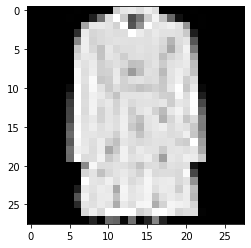

In [7]:
# Ploting the image in the sample[0][0]
# Plotting the lable of the sample[0]

print(image.shape)
print(label.shape)
plt.imshow(image[0][0].view(28,28),cmap='gray');
print('label :' ,label[0])

labels: tensor([3, 6, 4, 4, 1, 9, 8, 1, 4, 8])


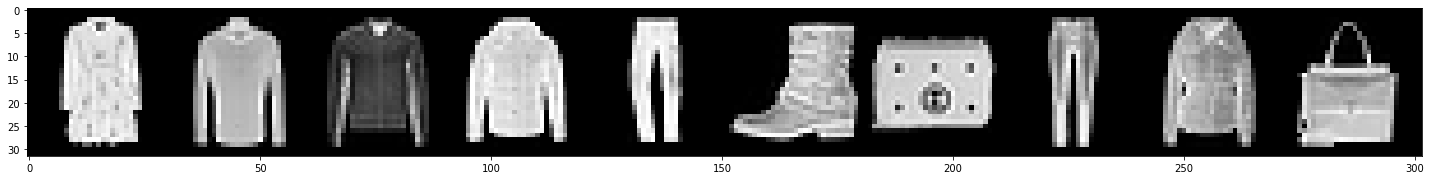

In [8]:
# printing the items of the batch
# using grid utility function

grid = torchvision.utils.make_grid(image,nrow=10)
plt.figure(figsize=(25,30))
plt.imshow(np.transpose(grid,(1,2,0)))
print('labels:',label)

### Modeling

In [11]:
class Network(nn.Module):
    '''
    Creating Neural Network class through
    1. extending the base neural network module of pytorch
    2. creating layers both convolutional and linear for CNN model
    3. assigning hyperparameters & data-dependent parameters
    that uses the inheritance method to use all the module functionality
    and allows the user to add their own custome functionality or change 
    the existing function using ( __ repr__) function
    
    Hyperparameters : out_channels, kernel_size(5,5), out_features
    Data dependent parameters : in_channel, out_feature at the last
    
    '''
    def __init__(self):
        super().__init__() # extending the Pytorch nn module class
        
        self.conv1 = nn.Conv2d(in_channels =1,out_channels = 6,kernel_size = 5,stride =1)
        self.conv2 = nn.Conv2d(in_channels =6,out_channels = 12,kernel_size = 5,stride =1)
        self.fc1 = nn.Linear(in_features = 12*4*4,out_features=120,bias = True)
        self.fc2 = nn.Linear(in_features = 120,out_features=60,bias =True)
        self.out = nn.Linear(60,10)
    
    def forward(self,t):
        # input layer (generally not required as all the data are passed to next layer without any change)
        t=t
        
        # hidden layer -1
        t=self.conv1(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size=2,stride=2)
        
        # hidden layer -2
        t=self.conv2(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size=2,stride=2)
        
        # hidden linear layer -1
        t=t.reshape(-1,12*4*4)
        t=self.fc1(t)
        t=F.relu(t)
        
        # hidden linear layer -2
        t=self.fc2(t)
        t=F.relu(t)
        
        # output layer
        t=self.out(t)
        
        return t
        
        
network = Network()
print(network)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [10]:
# Parameters in the CNN model
for name,param in network.named_parameters():
    print(name,'\t\t',param.shape)

conv1.weight 		 torch.Size([6, 1, 5, 5])
conv1.bias 		 torch.Size([6])
conv2.weight 		 torch.Size([12, 6, 5, 5])
conv2.bias 		 torch.Size([12])
fc1.weight 		 torch.Size([120, 192])
fc1.bias 		 torch.Size([120])
fc2.weight 		 torch.Size([60, 120])
fc2.bias 		 torch.Size([60])
out.weight 		 torch.Size([10, 60])
out.bias 		 torch.Size([10])


### Training with a single batch

In [19]:
# Training the model with a batch of 10 images

batch = next(iter(trainset))
images,labels = batch
print(images.shape)
print(labels.shape)

torch.Size([10, 1, 28, 28])
torch.Size([10])


In [20]:
# prediction
'''
The batch with 10 images are processed
in the neural network model and the 
probability is calculated using the
softmax function for each class row wise

'''
pred = network(images)
print(pred.shape)
pred

torch.Size([10, 10])


tensor([[-0.0003,  0.0145,  0.1376, -0.0305, -0.1517, -0.0849, -0.0288,  0.0679, -0.0324,  0.0889],
        [-0.0128, -0.0055,  0.1301, -0.0052, -0.1474, -0.0917, -0.0172,  0.0754, -0.0372,  0.0951],
        [-0.0103, -0.0046,  0.1298, -0.0097, -0.1487, -0.0977, -0.0190,  0.0758, -0.0332,  0.0930],
        [-0.0112, -0.0036,  0.1264, -0.0065, -0.1447, -0.0873, -0.0188,  0.0678, -0.0400,  0.0922],
        [-0.0115, -0.0022,  0.1317, -0.0165, -0.1529, -0.0960, -0.0192,  0.0776, -0.0370,  0.0960],
        [-0.0140,  0.0056,  0.1400, -0.0157, -0.1478, -0.0963, -0.0285,  0.0774, -0.0363,  0.0893],
        [-0.0071,  0.0005,  0.1355, -0.0134, -0.1534, -0.0945, -0.0178,  0.0748, -0.0381,  0.0897],
        [-0.0115, -0.0024,  0.1300, -0.0166, -0.1556, -0.1068, -0.0174,  0.0748, -0.0325,  0.0996],
        [-0.0136,  0.0036,  0.1342, -0.0139, -0.1555, -0.0931, -0.0191,  0.0746, -0.0396,  0.0930],
        [-0.0114,  0.0013,  0.1360, -0.0192, -0.1519, -0.0965, -0.0223,  0.0780, -0.0400,  0.0983]],

In [21]:
'''
using argmax function to determine
the index of the maximum occuring
probability for each image in the 
the batch

'''
pred.argmax(dim=1)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [22]:
'''

comparison between the original
labels & predicted labels from 
the model

'''
print(labels)
print(pred.argmax(dim=1).eq(labels))

def get_correct_pred(pred,labels):
    return pred.argmax(dim=1).eq(labels).sum().item()

print('Total correct predictions :',get_correct_pred(pred,labels))

tensor([8, 3, 3, 0, 6, 9, 4, 3, 2, 2])
tensor([False, False, False, False, False, False, False, False,  True,  True])
Total correct predictions : 2


### Calculating Loss. Gradient & Update Weights

In [15]:
# Calculate Gradient

print('Gradient values initially',network.conv1.weight.grad)

Gradient values initially None


In [16]:
# Calculate Loss & optimize
optimizer = torch.optim.SGD(network.parameters(), lr=0.01) 
batch = next(iter(trainset))
images,labels=batch
pred = network(images)
loss = F.cross_entropy(pred,labels)
loss.backward()
optimizer.step()

In [17]:
print('Gradient values after',network.conv1.weight.grad.shape)

Gradient values after torch.Size([6, 1, 5, 5])


In [18]:
print(loss.item())

2.3114733695983887


### Training with all batches : A single epoch

In [19]:
train_loader = torch.utils.data.DataLoader(train,batch_size=100)
optimizer = torch.optim.SGD(network.parameters(), lr=0.01) 
epochs = 1


for epoch in range(epochs):
    
    '''
    For each epoch, loop will fetch a batch,
    predict the values, calculate the loss,
    optimize the loss, upgrade the loss,
    repeat for the next epoch
    
    '''
    
    total_loss=0
    total_correct=0
    
    for batch in train_loader: # Get Batch
        images,labels = batch
        
        network.zero_grad()
        output = network(images) # Pass Batch
        loss=F.cross_entropy(output,labels) # Calculate loss
        
        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights
        
        total_loss += loss.item()
        total_correct += get_correct_pred(output,labels)
        
    print("epoch:",epoch,"loss:",loss,"total_correct:",total_correct)

epoch: 0 loss: tensor(2.2001, grad_fn=<NllLossBackward>) total_correct: 9173


In [20]:
print('Total % correct prediction ',total_correct*100/len(train))

Total % correct prediction  15.288333333333334


### Training with all batches : multiple epochs

In [21]:
epochs= 3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=0.01) 

for epoch in range(epochs):
    
    total_loss=0
    total_correct=0
    
    for batch in train_loader: # Get Batch
        
        # Load images
        images,labels = batch
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        output = network(images) # Pass Batch
        
        # Calculate Loss: softmax --> cross entropy loss
        loss=criterion(output,labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        #Get predictions from the maximum value
        total_correct += get_correct_pred(output,labels)
        total_loss += loss.item()
        
        
    accuracy = 100 * total_correct / len(train)
    # Print Loss
    print('Epoch:{}. Loss: {}. Accuracy: {}. Total_Correct: {}.'.format(epoch, total_loss, accuracy,total_correct))

Epoch:0. Loss: 762.1179916858673. Accuracy: 54.88. Total_Correct: 32928.
Epoch:1. Loss: 514.2459655404091. Accuracy: 67.015. Total_Correct: 40209.
Epoch:2. Loss: 449.28578412532806. Accuracy: 71.32666666666667. Total_Correct: 42796.


### Analyzing CNN Results - Builing & Plotting a Confusion Matrix

In [22]:
'''
Creating a function to collect
all the prediction on the batches
of the trainset and concatenate 
into a single prediction tensor

'''

def get_all_preds(model,loader):
    all_preds=torch.tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds=torch.cat((all_preds,preds),dim=0)
    return all_preds

In [23]:
# Increasing the batch size to gather
# all the predictions of 60,000 images

with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train,batch_size =10000)
    train_pred = get_all_preds(network, prediction_loader)

In [24]:
# Calculating total number of correct preds

print('Total correct prediction from CNN model is ',get_correct_pred(train_pred,train.targets))

Total correct prediction from CNN model is  44248


In [25]:
# Comparing the predictions

train.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [26]:
train_pred.argmax(dim=1)

tensor([9, 0, 1,  ..., 3, 6, 5])

In [27]:
# Pairing up the predictions & targets

stacked = torch.stack(
    (
        train.targets,
        train_pred.argmax(dim=1)
    )
    , dim =1 # column wise
)

In [28]:
stacked

tensor([[9, 9],
        [0, 0],
        [0, 1],
        ...,
        [3, 3],
        [0, 6],
        [5, 5]])

In [29]:
# Creating 10x10 confusion matrix

cmt = torch.zeros(10,10,dtype=torch.int32)
for p in stacked:
    j,k = p.tolist()
    cmt[j,k]=cmt[j,k]+1

cmt

tensor([[4469,  192,  323,  758,   53,   11,  116,    0,   76,    2],
        [  20, 5473,   88,  343,   57,    1,   16,    0,    1,    1],
        [  27,   46, 4265,   76, 1230,   22,  106,    0,  228,    0],
        [ 234,  205,  157, 5078,  265,    1,   41,    0,   19,    0],
        [   7,   75, 1574,  460, 3728,   13,   28,    0,  114,    1],
        [   1,    4,    3,    7,    4, 4957,    1,  822,   47,  154],
        [1166,   73, 3087,  464,  756,   11,  243,    0,  200,    0],
        [   0,    0,    0,    0,    0,  370,    0, 5251,   12,  367],
        [  12,   12,  294,   78,   53,   50,   19,   30, 5449,    3],
        [   0,    0,    0,    3,    0,  113,    1,  539,    9, 5335]], dtype=torch.int32)

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

np.set_printoptions(precision=2)

Confusion matrix, without normalization


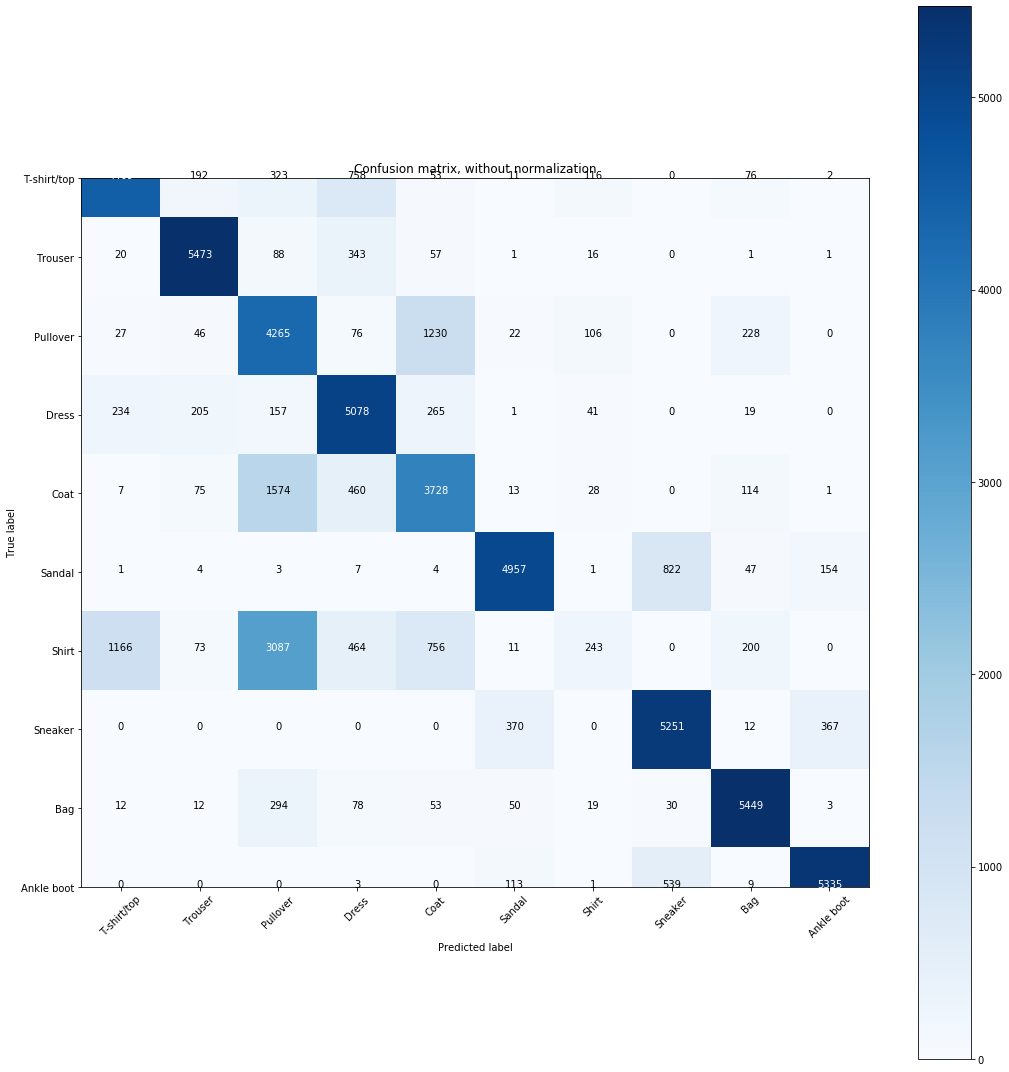

In [31]:
names = ('T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')
plt.figure(figsize=(15,15));
plot_confusion_matrix(cmt, classes=names,
                      title='Confusion matrix, without normalization');

### PyTorch & Tensorboard

In [13]:
#  Plotting one batch of 100 images on Tensorboard
train_loader = torch.utils.data.DataLoader(train,batch_size=100)
writer = SummaryWriter('C:/important_files/log/log_summary') # directory to the event file
network = Network()
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0, walltime=None, dataformats='CHW')
writer.add_graph(network, images)
writer.close()

In [24]:
# Adding CNN data to tensorflow
epochs= 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=0.01) 
train_loader = torch.utils.data.DataLoader(train,batch_size=100)
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)

writer = SummaryWriter('C:/important_files/log/log_summary') # directory to the event file
writer.add_image('images', grid, 0, walltime=None, dataformats='CHW')
writer.add_graph(network, images)
writer.close()

for epoch in range(epochs):
    
    total_loss=0
    total_correct=0
    
    for batch in train_loader: # Get Batch
        
        # Load images
        images,labels = batch
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        output = network(images) # Pass Batch
        
        # Calculate Loss: softmax --> cross entropy loss
        loss=criterion(output,labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        #Get predictions from the maximum value
        total_correct += get_correct_pred(output,labels)
        total_loss += loss.item()
        
    writer.add_scalar('Loss',total_loss,epoch)
    writer.add_scalar('Number Correct',total_correct,epoch)
    writer.add_scalar('Accuracy',total_correct*100/len(train),epoch)
    
    writer.add_histogram('conv1.bias',network.conv1.bias,epoch)
    writer.add_histogram('conv1.weight',network.conv1.weight,epoch)
    writer.add_histogram('conv1.weight.grad',network.conv1.weight.grad,epoch)
    accuracy = 100 * total_correct / len(train)
    print('Epoch:{}. Loss: {}. Accuracy: {}. Total_Correct: {}.'.format(epoch, total_loss, accuracy, total_correct))
    
writer.close()

Epoch:0. Loss: 775.6401156783104. Accuracy: 54.44166666666667. Total_Correct: 32665.
Epoch:1. Loss: 510.52538853883743. Accuracy: 67.52333333333333. Total_Correct: 40514.
Epoch:2. Loss: 451.4833643436432. Accuracy: 71.25. Total_Correct: 42750.
Epoch:3. Loss: 415.4904209971428. Accuracy: 73.695. Total_Correct: 44217.
Epoch:4. Loss: 388.81980046629906. Accuracy: 75.475. Total_Correct: 45285.


In [40]:
%load_ext tensorboard
%tensorboard --logdir C:/important_files/log/log_summary --port 8090

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 8090 (pid 2160), started 0:01:04 ago. (Use '!kill 2160' to kill it.)

### Hyperparameter Tuning 

In [26]:
from itertools import product

In [34]:
# Creating a parameter dictionary
parameters = dict(
lr = [0.01,0.001]
,batch_size =[10,100]
,shuffle =[True,False]
)

# Creating a cartesian product of all values
param_values = [v for v in parameters.values()]
for lr, batch_size, shuffle in product(*param_values):
    print(lr,batch_size,shuffle)

0.01 10 True
0.01 10 False
0.01 100 True
0.01 100 False
0.001 10 True
0.001 10 False
0.001 100 True
0.001 100 False


In [38]:
# Adding CNN data to tensorflow
epochs= 5
criterion = nn.CrossEntropyLoss()

for lr, batch_size, shuffle in product(*param_values):
    
    optimizer = torch.optim.SGD(network.parameters(), lr=lr) 
    train_loader = torch.utils.data.DataLoader(train,batch_size=batch_size)
    
    comment = f' batch_size={batch_size} lr ={lr} shuffle = {shuffle}'
    writer = SummaryWriter('C:\important_files\log\log_summary',comment=comment) # directory to the event file

    for epoch in range(epochs):
    
        total_loss=0
        total_correct=0
    
        for batch in train_loader: # Get Batch
        
            # Load images
            images,labels = batch
        
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
        
            # Forward pass to get output/logits
            output = network(images) # Pass Batch
        
            # Calculate Loss: softmax --> cross entropy loss
            loss=criterion(output,labels)
        
            # Getting gradients w.r.t. parameters
            loss.backward()
        
            # Updating parameters
            optimizer.step()
        
            #Get predictions from the maximum value
            total_correct += get_correct_pred(output,labels)
            total_loss += loss.item() * batch_size
        
        writer.add_scalar('Loss',total_loss,epoch)
        writer.add_scalar('Number Correct',total_correct,epoch)
        writer.add_scalar('Accuracy',total_correct*100/len(train),epoch)
    
        writer.add_histogram('conv1.bias',network.conv1.bias,epoch)
        writer.add_histogram('conv1.weight',network.conv1.weight,epoch)
        writer.add_histogram('conv1.weight.grad',network.conv1.weight.grad,epoch)
        accuracy = 100 * total_correct / len(train)
        print('Epoch:{}. Loss: {}. Accuracy: {}. Total_Correct: {}. Lr:{}. Batch_size:{}. Shuffle:{}.'.format(epoch, total_loss, accuracy, total_correct,lr,batch_size,shuffle))
    
writer.close()

Epoch:0. Loss: 15527.318308112444. Accuracy: 90.43166666666667. Total_Correct: 54259. Lr:0.01. Batch_size:10. Shuffle:True.
Epoch:1. Loss: 15078.281813163194. Accuracy: 90.67666666666666. Total_Correct: 54406. Lr:0.01. Batch_size:10. Shuffle:True.
Epoch:2. Loss: 14665.04998592136. Accuracy: 90.97. Total_Correct: 54582. Lr:0.01. Batch_size:10. Shuffle:True.
Epoch:3. Loss: 14265.35836710129. Accuracy: 91.23166666666667. Total_Correct: 54739. Lr:0.01. Batch_size:10. Shuffle:True.
Epoch:4. Loss: 13905.176757046138. Accuracy: 91.41. Total_Correct: 54846. Lr:0.01. Batch_size:10. Shuffle:True.
Epoch:0. Loss: 13538.831863292726. Accuracy: 91.61833333333334. Total_Correct: 54971. Lr:0.01. Batch_size:10. Shuffle:False.
Epoch:1. Loss: 13219.291755487793. Accuracy: 91.89333333333333. Total_Correct: 55136. Lr:0.01. Batch_size:10. Shuffle:False.
Epoch:2. Loss: 12873.662093482271. Accuracy: 92.13166666666666. Total_Correct: 55279. Lr:0.01. Batch_size:10. Shuffle:False.
Epoch:3. Loss: 12557.0141818575

In [41]:
%load_ext tensorboard
%tensorboard --logdir C:/important_files/log/log_summary --port 8090

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 8090 (pid 2160), started 0:01:50 ago. (Use '!kill 2160' to kill it.)